In [1]:
! pip install --upgrade ..  > /dev/null

In [2]:
!tree -h ../data/design_matrix/sample_6_8_50

../data/design_matrix/sample_6_8_50
├── [   0]  _SUCCESS
└── [137M]  part-00000-d8cb02f0-7e97-40bf-99fc-b91aeb0fc6e4-c000.snappy.parquet

0 directories, 2 files


In [3]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


N_CUTS = 8
START_DATE = datetime.strptime("2018-01-01", "%Y-%m-%d")
END_DATE = datetime.strptime("2019-09-01", "%Y-%m-%d")

META = ["partition_id", "title"]
DEGREE = ["degree", "inDegree", "outDegree"]
SIGN = [f"sign_{i}" for i in range(N_CUTS)]
VECTOR = [f"fiedler_{i}" for i in range(N_CUTS)]
DATES = [(START_DATE + timedelta(t)).strftime("%Y-%m-%d")
         for t in range((END_DATE-START_DATE).days)]

SCHEMA = META + DEGREE + SIGN + VECTOR + DATES


data = pd.read_parquet(glob.glob("../data/design_matrix/sample_6_8_50/*.parquet")[0])
pretty_columns = META+DEGREE+SIGN[:1]+VECTOR[:1]+DATES[:3]
data.loc[:, pretty_columns].sample(5)

,partition_id,title,degree,inDegree,outDegree,sign_0,fiedler_0,2018-01-01,2018-01-02,2018-01-03
291796,xxoxxxox,Maohou,461.0,220.0,241.0,True,2.832835e-10,385.0,557.0,432.0
296613,ooxoxoxo,P._indica,382.0,54.0,328.0,False,-3.344443e-10,NaN,NaN,NaN
129132,ooooooox,Zirnay,194.0,85.0,109.0,False,-3.221264e-10,NaN,NaN,172.0
254305,xxoxxoox,Breezy_Bishop,49.0,15.0,34.0,True,1.611432e-10,NaN,NaN,NaN
63437,ooxooxxx,Mary_Margaret_Haugen,114.0,6.0,108.0,False,-5.382196e-10,NaN,NaN,NaN


# Data preprocessing and plotting

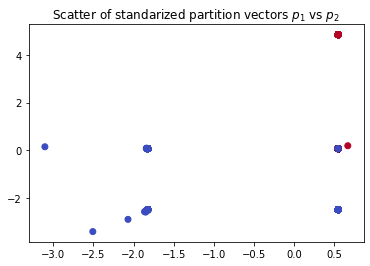

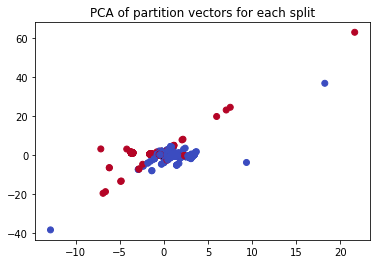

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sample_size = 10**4
sample = data.fillna(0.0).sample(sample_size)

scaler = StandardScaler()
minmax = MinMaxScaler()
pca = PCA(n_components=2)

labels = sample[SIGN[0]].values.astype(int)
z = sample[VECTOR]
z = scaler.fit_transform(z)
G = pca.fit_transform(z)

plt.title("Scatter of standarized partition vectors $p_1$ vs $p_2$")
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="coolwarm")
plt.show()

plt.title("PCA of partition vectors for each split")
plt.scatter(G[:, 0], G[:, 1], c=labels, cmap="coolwarm")
plt.show()

## Gaussian Mixture Model

See [an example of contours with mixture models](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.htmlsphx-glr-auto-examples-mixture-plot-gmm-pdf-py) and [GMM covariances](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)

In [491]:
pd.DataFrame(sample.groupby(by=SIGN[:3]).count()["id"])

id
sign_0 sign_1 sign_2      
False  False  False   1713
              True    1325
       True   False   1267
              True    1438
True   False  False   1110
              True    1052
       True   False   1147
              True     948

CPU times: user 7.03 s, sys: 627 ms, total: 7.66 s
Wall time: 2.51 s


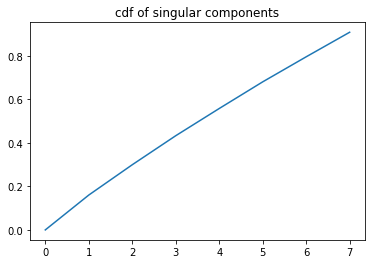

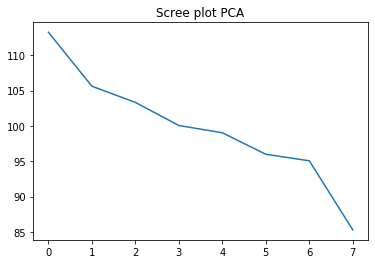

((10000, 10000), (8,), (8, 8))

In [492]:
%time u, s, vh = np.linalg.svd(z)

x = np.arange(s.size)
y = [np.square(s[:k]).sum()/np.square(s).sum() for k in range(s.size)]
plt.title("cdf of singular components")
plt.plot(x, y)
plt.show()

plt.title("Scree plot PCA")
plt.plot(x, s)
plt.show()

u.shape, s.shape, vh.shape

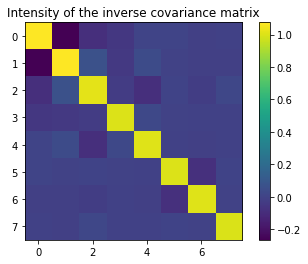

In [493]:
precisions = np.linalg.pinv(np.cov(z.T))
plt.title("Intensity of the inverse covariance matrix")
plt.imshow(precisions)
plt.colorbar()
plt.show()

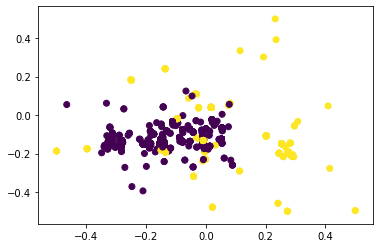

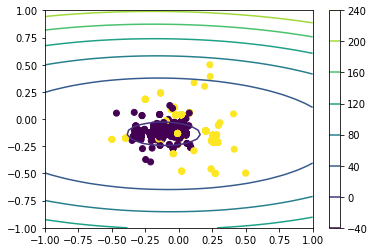

In [521]:
from sklearn.mixture import GaussianMixture

estimator = GaussianMixture(
    n_components=2, 
    tol=0.001, 
    init_params='kmeans',
    covariance_type='full',
)
zz = MinMaxScaler().fit_transform(G)-0.5
estimator.fit(zz[:,:2])

plt.scatter(zz[:,0], zz[:,1], c=labels)
plt.show()

# display predicted scores by the model as a contour plot
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -estimator.score_samples(XX)
Z = Z.reshape(X.shape)

fig = plt.figure()
CS = plt.contour(X, Y, Z)
CB = plt.colorbar(CS)
plt.scatter(zz[:, 0], zz[:, 1], c=labels)
plt.show()